In [1]:
# Dowload the packages
!pip install split-folders

In [2]:
!pip install tensorflow==2.3.0


ERROR: Could not find a version that satisfies the requirement tensorflow==2.3.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0)
ERROR: No matching distribution found for tensorflow==2.3.0


In [3]:
# Dowload the packages
import numpy as np
import pandas as pd
import os,os.path
import splitfolders
import shutil

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib

import keras.backend as K
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from tensorflow.keras import Model
#from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory

matplotlib.style.use('ggplot')
%matplotlib inline

In [4]:
# Set some default variables
DATA_DIR = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
BATCH_SIZE = 128
EPOCHS = 30
IMAGE_SHAPE = (224, 224)

In [5]:
import keras.backend as K

def f1_macro(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives + K.epsilon())    
        return recall 

    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives + K.epsilon())
        return precision 

    def accuracy_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
        total_samples = K.cast(K.shape(y_true)[0], dtype='float32')

        accuracy = (true_positives + true_negatives) / total_samples
        return accuracy

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    accuracy = accuracy_m(y_true, y_pred)
    
    return {
        'f1_macro': 2 * ((precision * recall) / (precision + recall + K.epsilon())),
        'accuracy': accuracy
    }


In [6]:
# Check the content

pairs = list()
number = list()

for directory in os.listdir(path=DATA_DIR):
    columns = directory.split('___')
    columns.append(directory)
    
    sub_path = DATA_DIR + '/' + directory
    columns.append(len([name for name in os.listdir(path=sub_path)]))
    
    pairs.append(columns)
    
pairs = pd.DataFrame(pairs, columns=['Plant', 'Disease', 'Directory', 'Files'])
pairs.sort_values(by='Plant')

,Plant,Disease,Directory,Files
27,Apple,healthy,Apple___healthy,2008
20,Apple,Cedar_apple_rust,Apple___Cedar_apple_rust,1760
16,Apple,Black_rot,Apple___Black_rot,1987
13,Apple,Apple_scab,Apple___Apple_scab,2016
17,Blueberry,healthy,Blueberry___healthy,1816
18,Cherry_(including_sour),Powdery_mildew,Cherry_(including_sour)___Powdery_mildew,1683
30,Cherry_(including_sour),healthy,Cherry_(including_sour)___healthy,1826
31,Corn_(maize),Common_rust_,Corn_(maize)___Common_rust_,1907
10,Corn_(maize),Cercospora_leaf_spot Gray_leaf_spot,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,1642
37,Corn_(maize),healthy,Corn_(maize)___healthy,1859


In [7]:
# Make a directory images
os.mkdir('images')

# Make subdirectories train, val, test
os.mkdir(os.path.join('images', 'train'))
os.mkdir(os.path.join('images', 'val'))
os.mkdir(os.path.join('images', 'test'))

In [8]:
# Split the data into folders
splitfolders.ratio(DATA_DIR,output = "images",seed = 42,ratio = (0.80,0.10,0.10))

Copying files: 70295 files [07:48, 149.94 files/s]


In [9]:
# Remove the directories we saved before

TRAIN_PATH = "./images/train"
VAL_PATH = "./images/val"
TEST_PATH  = "./images/test"
PATHS = [TRAIN_PATH, VAL_PATH, TEST_PATH]



In [10]:
# Generate batches of tensor image data with real-time data augmentation

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

train_gen = datagen.flow_from_directory(directory = TRAIN_PATH, 
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

val_gen = datagen.flow_from_directory(directory = VAL_PATH, 
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

test_gen = datagen.flow_from_directory(directory = TEST_PATH, 
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          shuffle = False)

Found 56219 images belonging to 38 classes.
Found 7013 images belonging to 38 classes.
Found 7063 images belonging to 38 classes.


In [11]:
# Make a directory for models
os.mkdir('models')

# Make subdirectories train, val, test
os.mkdir(os.path.join('models', 'first_version'))

In [12]:
# # Make a directory for models
# os.mkdir('/kaggle/working/models')

# # Make subdirectories train, val, test
# os.mkdir(os.path.join('models', 'first_version'))

In [13]:
# Here we create checkpoint for the first model
CHECKPOINT_PATH_MODEL_FIRST = "./models/first_version_2.keras"
# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH_MODEL_FIRST,
#                                       monitor='val_loss',
#                                       save_best_only=True)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH_MODEL_FIRST,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [14]:
# # Set early stopping for 2 epochs
# early_stopping = EarlyStopping(monitor='val_loss', patience = 2, restore_best_weights=True)


# # # Early stopping callback
# # early_stopping = EarlyStopping(
# #     monitor='val_loss',
# #     patience=5,
# #     verbose=1,
# #     restore_best_weights=True
# # )

In [15]:
# ... (previous code)

from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Use pre-trained ResNet152V2 model as the base model
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classifier on top of the pre-trained model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(38, activation='softmax')(x)

# Create the model
resnet152v2_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
resnet152v2_model.compile(optimizer=Adam(learning_rate=0.001),
                          loss='categorical_crossentropy',
                          metrics=['accuracy', f1_macro])

# Display the model summary
resnet152v2_model.summary()




234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 59,400,230 (226.59 MB)

 Trainable params: 1,068,582 (4.08 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

In [16]:
resnet152v2_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=5,  # Number of epochs with no improvement to wait
    verbose=1,
    restore_best_weights=True  # Restore the best weights when stopping
)

In [18]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    checkpoint_callback,  # Save weights every epoch
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
]

In [19]:
print(len(train_gen))

440


In [20]:
# history = resnet152v2_model.fit(
#     train_gen,
#     steps_per_epoch=len(train_gen),
#     epochs=40,
#     validation_data=val_gen,
#     validation_steps=len(val_gen),
#     verbose=1,
#     callbacks=callbacks # Use early stopping callback based on accuracy
# )

history = resnet152v2_model.fit(
    train_gen,
    #steps_per_epoch=len(train_gen),
    epochs=25,
    validation_data=val_gen ,
    #validation_steps=len(val_gen),  # Adjust if needed
    verbose=1,
    #callbacks=callbacks
)


# history = resnet152v2_model.fit(
#     train_gen,
#     steps_per_epoch=len(train_gen),
#     epochs=40,
#     validation_data=val_gen,
#     validation_steps=len(val_gen),
#     verbose=1,
#     callbacks=[early_stopping, checkpoint_callback]
# )


# Evaluate the model on the test dataset using test_gen
test_loss, test_accuracy = resnet152v2_model.evaluate(test_gen, steps=len(test_gen))
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730962092.160702      97 service.cc:145] XLA service 0x7bceec02ba40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730962092.160764      97 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1730962107.805157      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


440/440 ━━━━━━━━━━━━━━━━━━━━ 235s 454ms/step - accuracy: 0.6789 - loss: 1.1458 - val_accuracy: 0.9278 - val_loss: 0.2320
Epoch 2/25
440/440 ━━━━━━━━━━━━━━━━━━━━ 173s 388ms/step - accuracy: 0.9058 - loss: 0.2850 - val_accuracy: 0.9424 - val_loss: 0.1835
Epoch 3/25
440/440 ━━━━━━━━━━━━━━━━━━━━ 173s 388ms/step - accuracy: 0.9297 - loss: 0.2123 - val_accuracy: 0.9509 - val_loss: 0.1518
Epoch 4/25
440/440 ━━━━━━━━━━━━━━━━━━━━ 172s 387ms/step - accuracy: 0.9441 - loss: 0.1673 - val_accuracy: 0.9518 - val_loss: 0.1426
Epoch 5/25
440/440 ━━━━━━━━━━━━━━━━━━━━ 202s 387ms/step - accuracy: 0.9527 - loss: 0.1406 - val_accuracy: 0.9634 - val_loss: 0.1218
Epoch 6/25
440/440 ━━━━━━━━━━━━━━━━━━━━ 172s 387ms/step - accuracy: 0.9549 - loss: 0.1294 - val_accuracy: 0.9588 - val_loss: 0.1284
Epoch 7/25
440/440 ━━━━━━━━━━━━━━━━━━━━ 172s 387ms/step - accuracy: 0.9585 - loss: 0.1177 - val_accuracy: 0.9595 - val_loss: 0.1284
Epoch 8/25
440/440 ━━━━━━━━━━━━━━━━━━━━ 202s 387ms/step - accuracy: 0.9617 - loss: 0.10

In [21]:

# # Evaluate the model on the test dataset using test_gen
# test_loss, test_accuracy = resnet152v2_model.evaluate(test_gen, steps=len(test_gen))
# print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


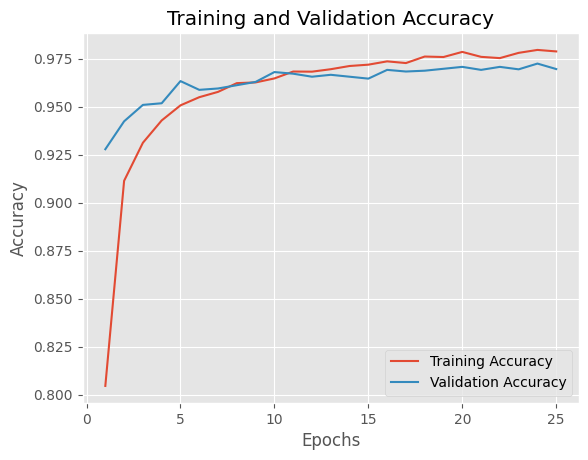

In [22]:
import matplotlib.pyplot as plt

# Assuming you have a 'history' object containing accuracy and validation accuracy values

# Extract accuracy and validation accuracy from the 'history' object
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a list of epoch numbers
epochs = range(1, len(accuracy) + 1)

# Plot accuracy
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()


In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, AveragePooling2D, Flatten, Dense, Input
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

In [24]:
# ... (previous code)
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
# Evaluate the model on the test dataset using test_gen
test_loss, test_accuracy = resnet152v2_model.evaluate(test_gen, steps=len(test_gen))
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Predict labels for the test data
predictions = resnet152v2_model.predict(test_gen)
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels for the test data
true_labels = test_gen.classes

# Calculate confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)
print('Confusion Matrix:')
print(confusion)

# Define the number of classes in your dataset (replace with the actual number)
num_classes = 38

# Calculate precision, recall, and F1 score for each class
class_precision = precision_score(true_labels, predicted_labels, average=None)
class_recall = recall_score(true_labels, predicted_labels, average=None)
class_f1_score = f1_score(true_labels, predicted_labels, average=None)

# Calculate macro-average precision, recall, and F1 score
macro_precision = np.mean(class_precision)
macro_recall = np.mean(class_recall)
macro_f1_score = np.mean(class_f1_score)

# Calculate micro-average precision, recall, and F1 score
micro_precision = precision_score(true_labels, predicted_labels, average='micro')
micro_recall = recall_score(true_labels, predicted_labels, average='micro')
micro_f1_score = f1_score(true_labels, predicted_labels, average='micro')

print('Class-wise Metrics:')
for i in range(num_classes):
    print(f'Class {i + 1}: Precision = {class_precision[i]:.4f}, Recall = {class_recall[i]:.4f}, F1 Score = {class_f1_score[i]:.4f}')

print(f'Macro-average Precision = {macro_precision:.4f}, Recall = {macro_recall:.4f}, F1 Score = {macro_f1_score:.4f}')
print(f'Micro-average Precision = {micro_precision:.4f}, Recall = {micro_recall:.4f}, F1 Score = {micro_f1_score:.4f}')


56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 338ms/step - accuracy: 0.9796 - loss: 0.0694
Test Loss: 0.1024, Test Accuracy: 0.9693
56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 460ms/step
Confusion Matrix:
[[192   3   1 ...   0   0   0]
 [  0 200   0 ...   0   0   0]
 [  0   0 175 ...   0   0   0]
 ...
 [  0   0   0 ... 192   0   0]
 [  0   0   0 ...   0 178   0]
 [  0   0   0 ...   0   0 185]]
Class-wise Metrics:
Class 1: Precision = 0.9846, Recall = 0.9458, F1 Score = 0.9648
Class 2: Precision = 0.9662, Recall = 1.0000, F1 Score = 0.9828
Class 3: Precision = 0.9831, Recall = 0.9943, F1 Score = 0.9887
Class 4: Precision = 0.9802, Recall = 0.9802, F1 Score = 0.9802
Class 5: Precision = 0.9733, Recall = 0.9945, F1 Score = 0.9838
Class 6: Precision = 1.0000, Recall = 0.9882, F1 Score = 0.9940
Class 7: Precision = 0.9892, Recall = 1.0000, F1 Score = 0.9946
Class 8: Precision = 0.9811, Recall = 0.9455, F1 Score = 0.9630
Class 9: Precision = 1.0000, Recall = 1.0000, F1 Score = 1.0000
Class 10: Precision = 0.9592, Recal

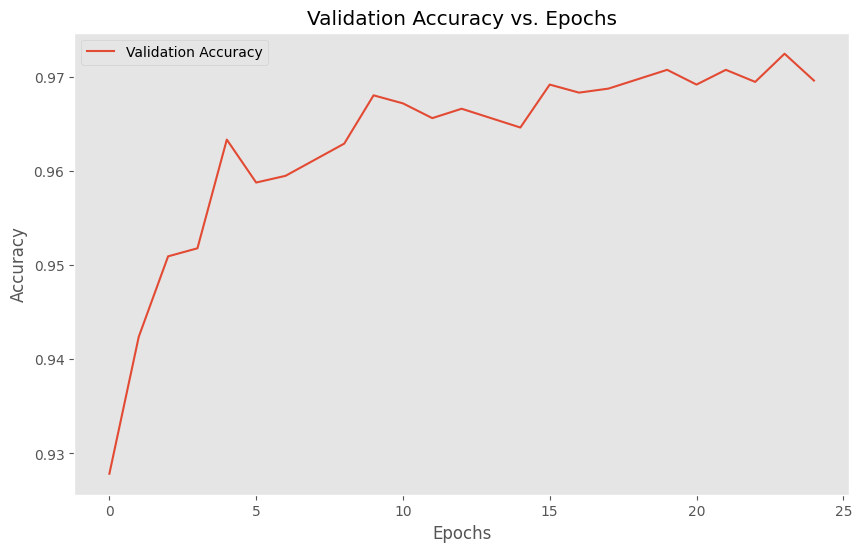

In [25]:
# Plot validation accuracy vs. epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs. Epochs')
plt.legend()
plt.grid()
plt.show()


56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 327ms/step


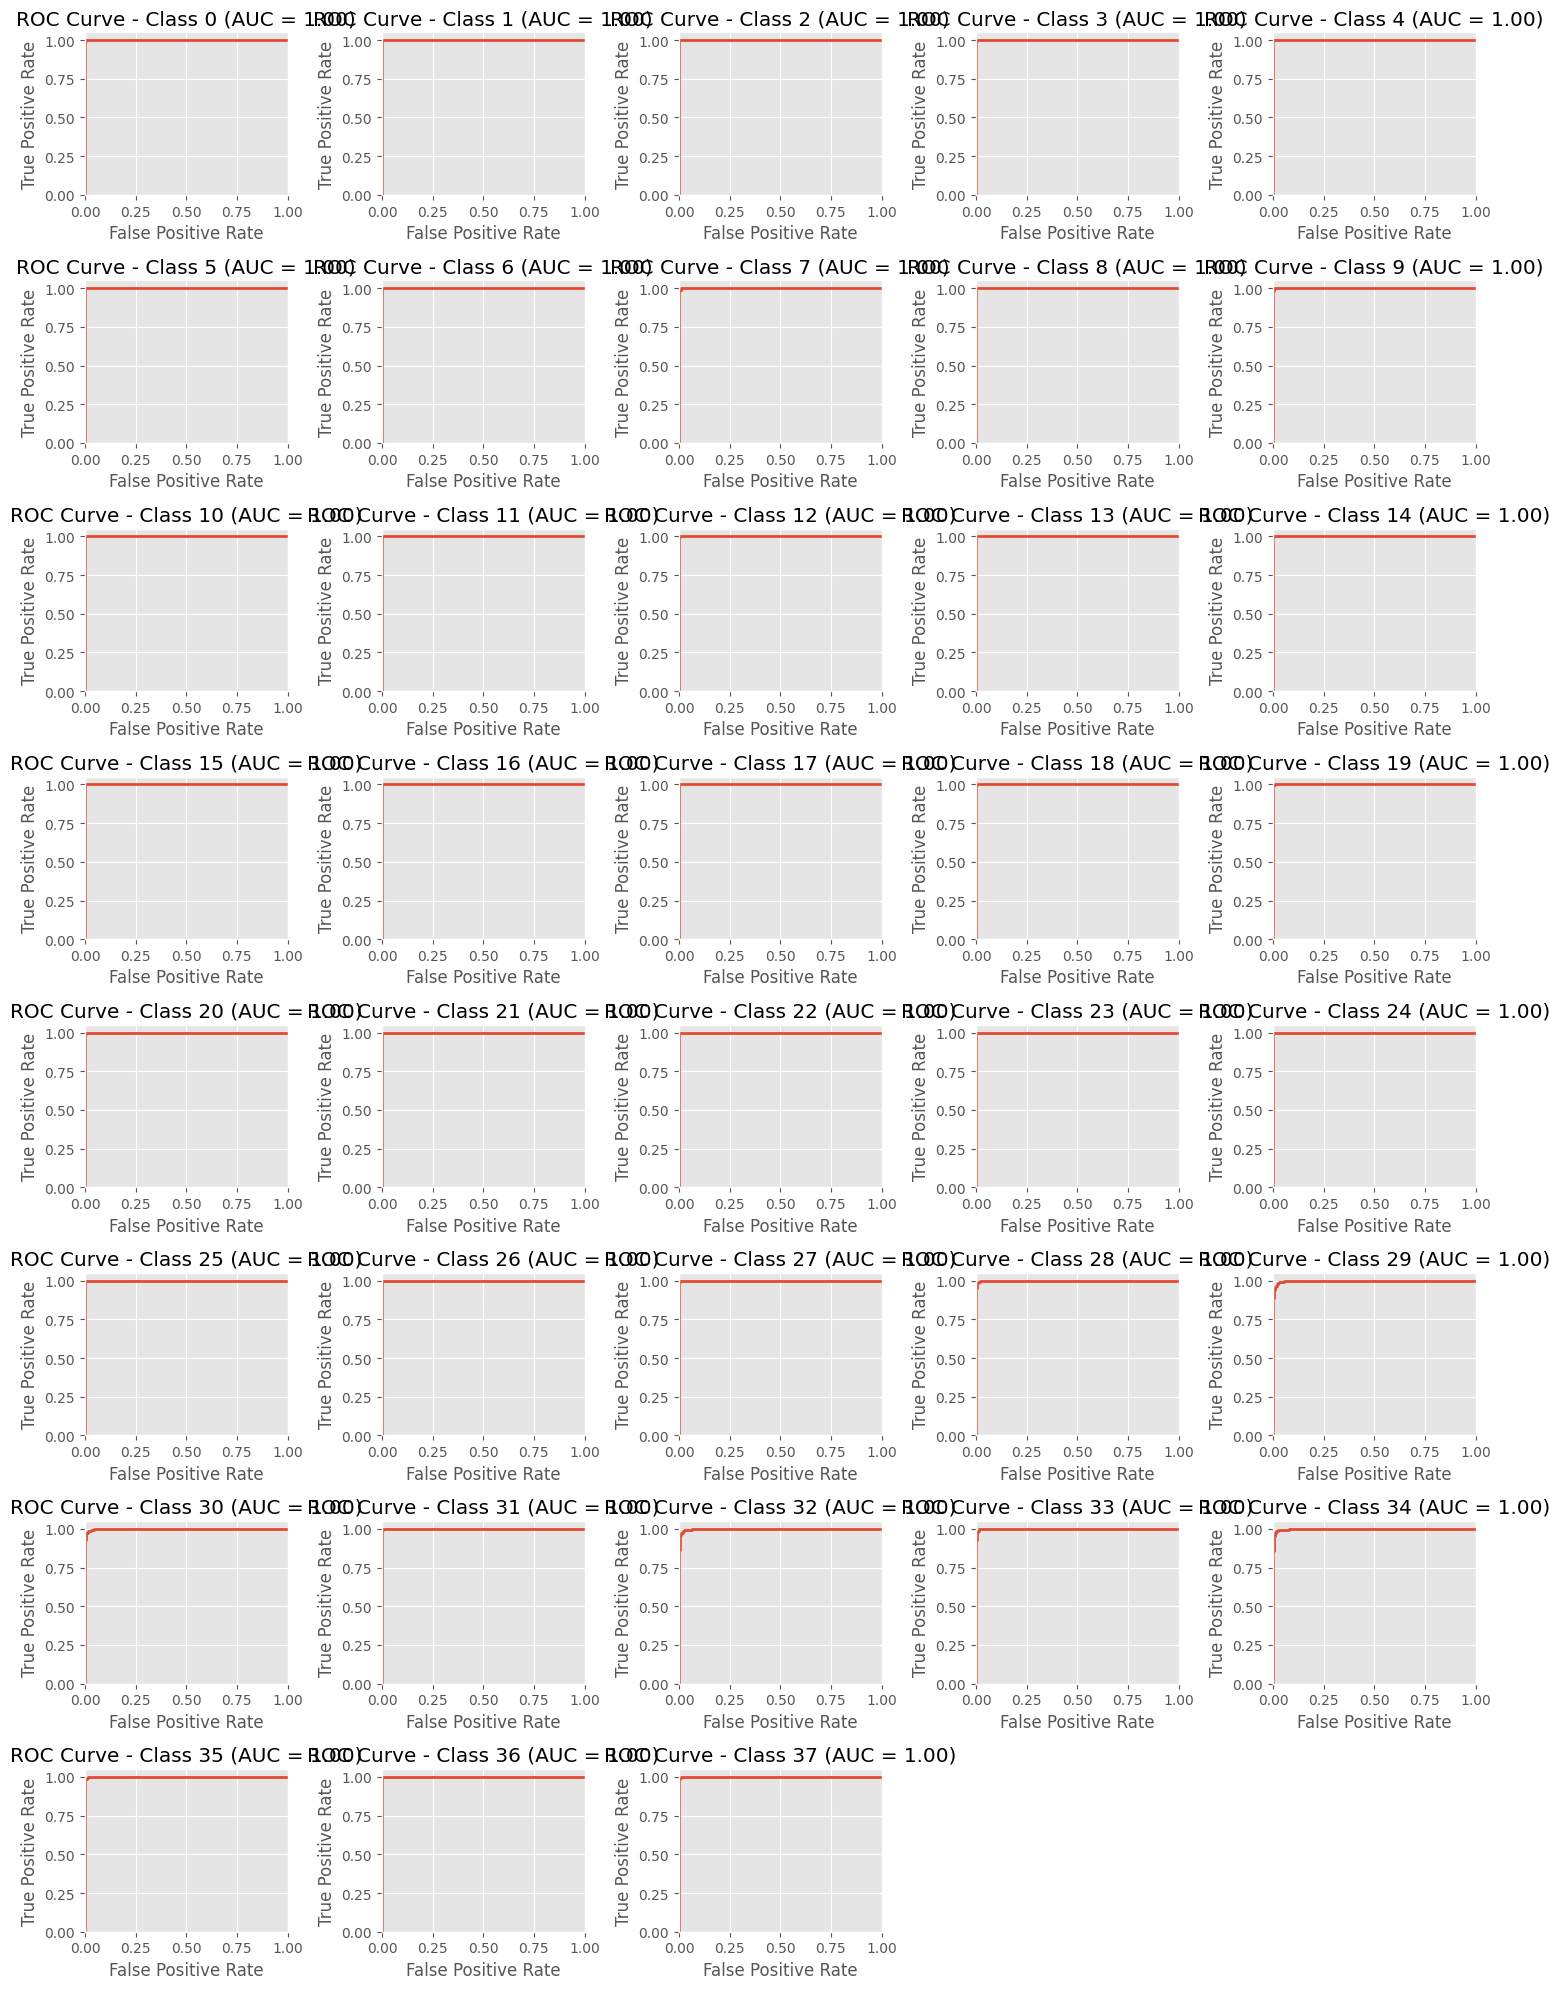

In [26]:
# Assuming you have a trained model and test data
predicted_probs = resnet152v2_model.predict(test_gen)  # Use the test generator to predict

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Initialize dictionaries to store fpr, tpr, and auc for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(15, 20))  # Adjust the figure size as needed

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_gen.classes == i, predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Create a subplot for each class
    plt.subplot(8, 5, i + 1)  # Assumes a 5x8 grid, adjust as needed
    plt.plot(fpr[i], tpr[i], lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Class {i} (AUC = {roc_auc[i]:.2f})')

plt.tight_layout()
plt.show()


56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 327ms/step


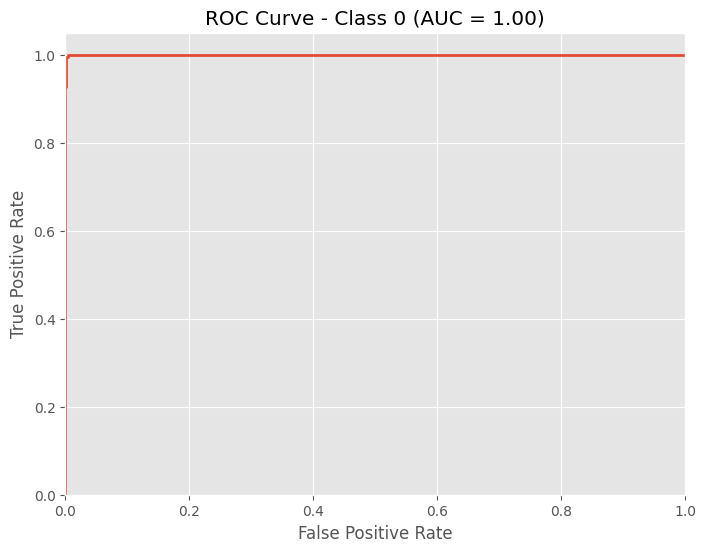

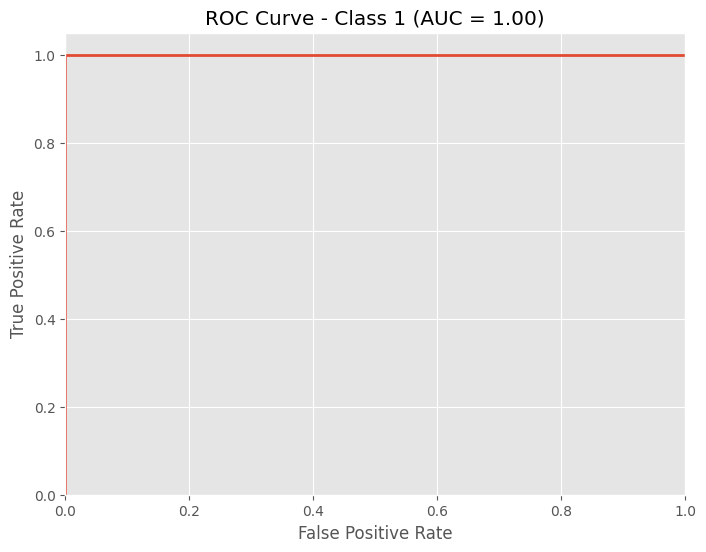

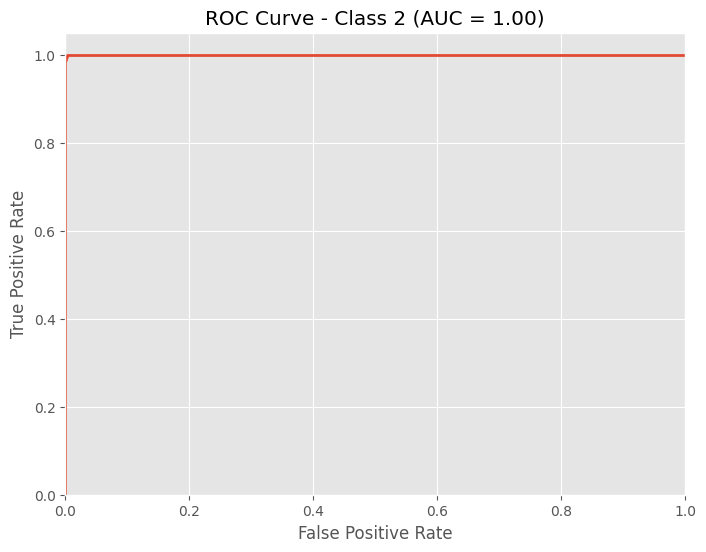

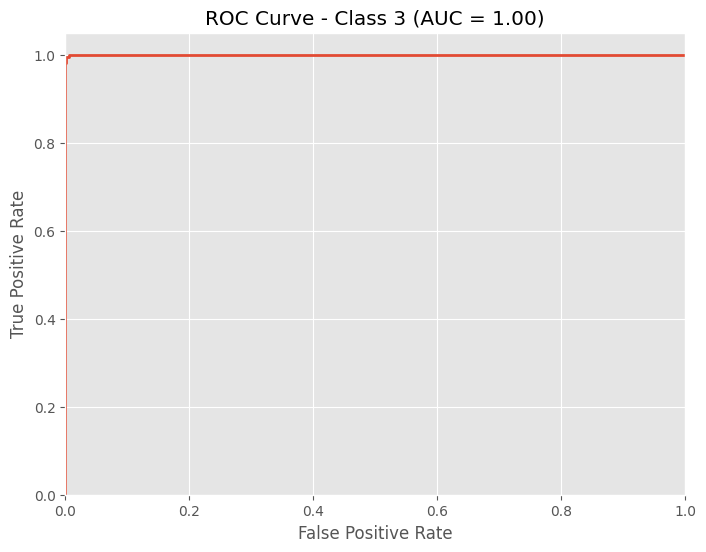

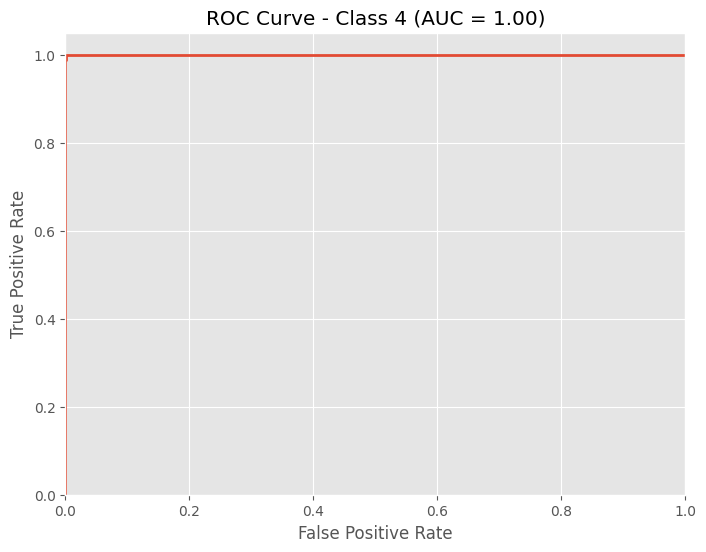

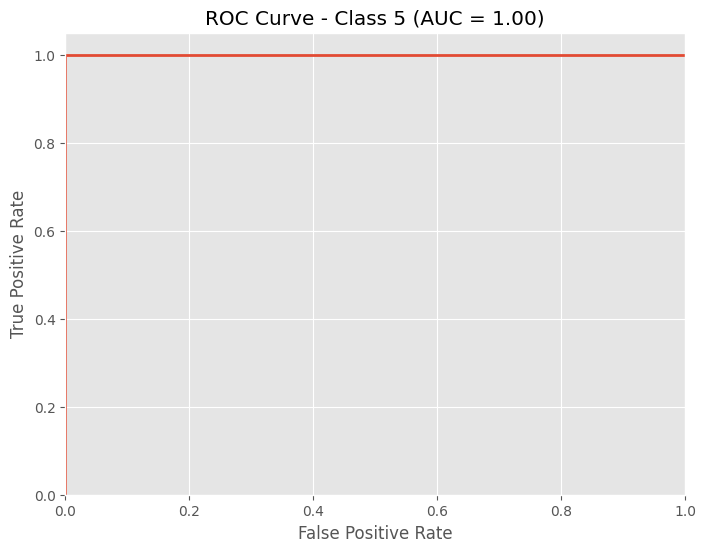

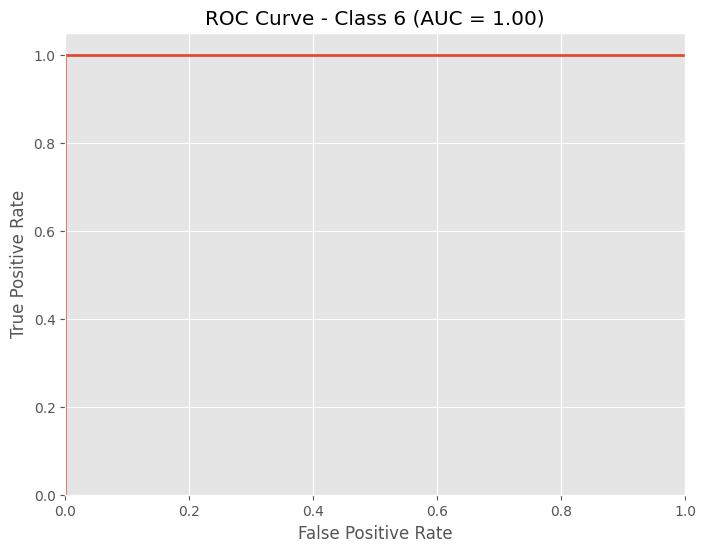

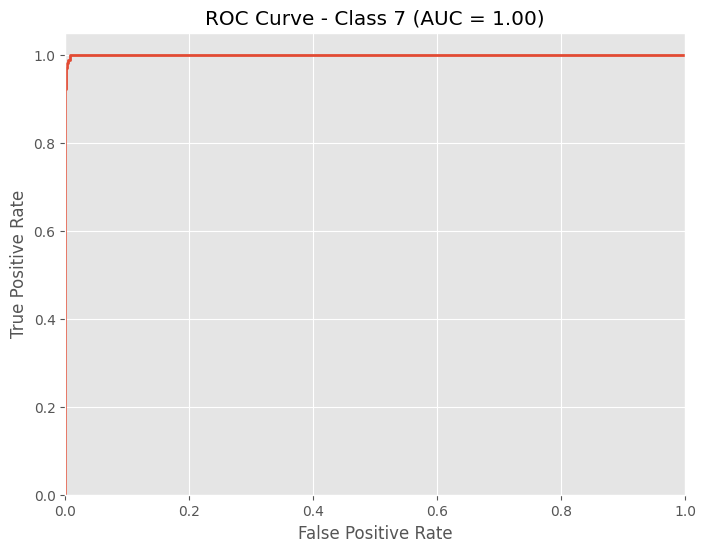

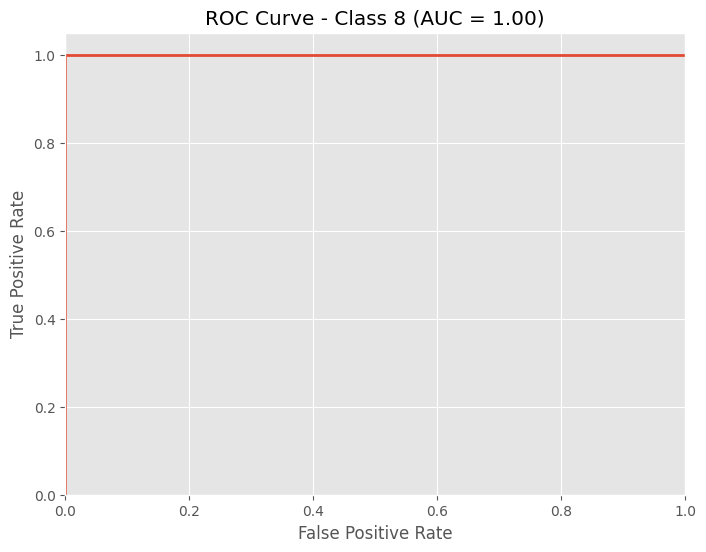

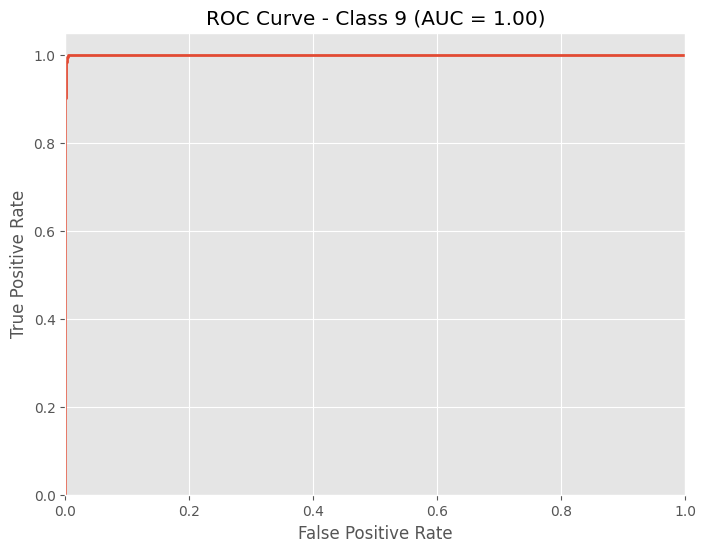

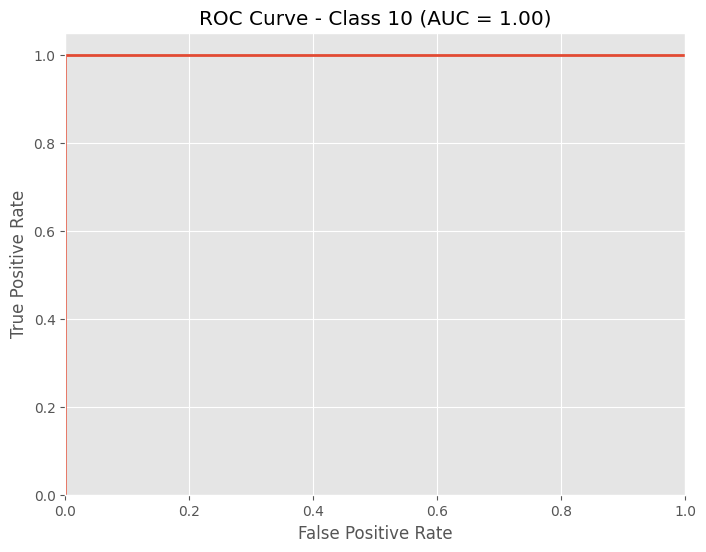

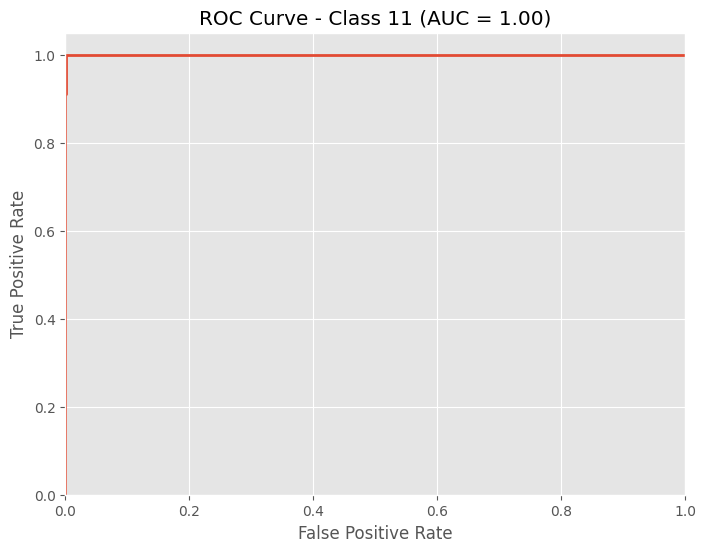

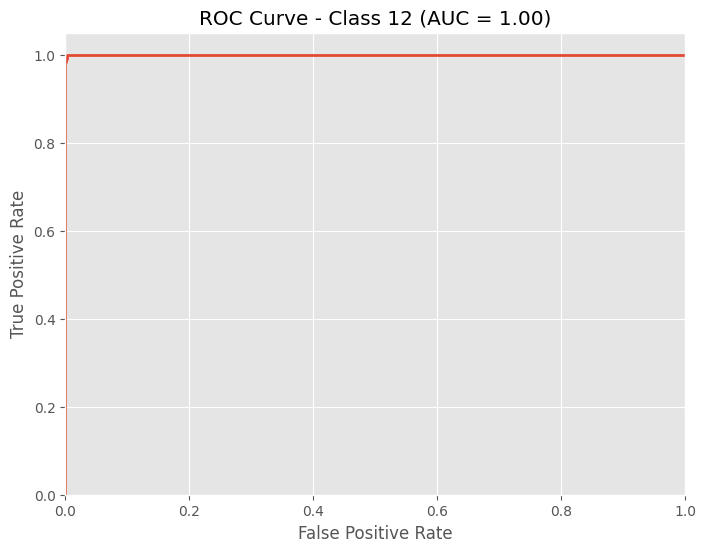

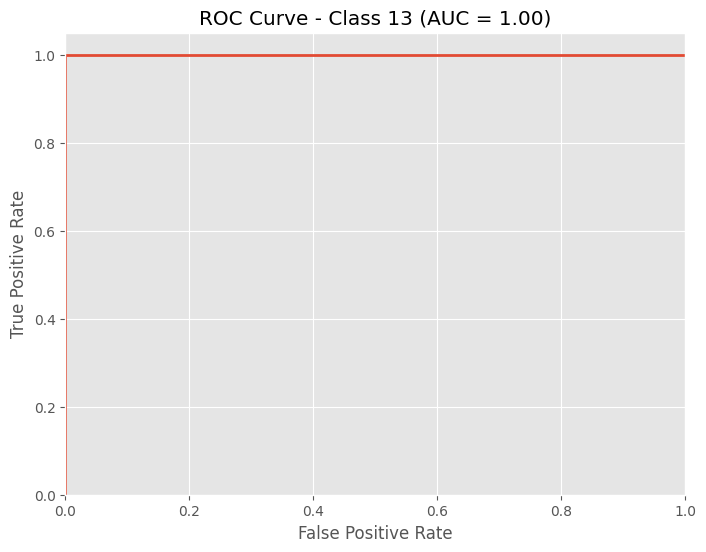

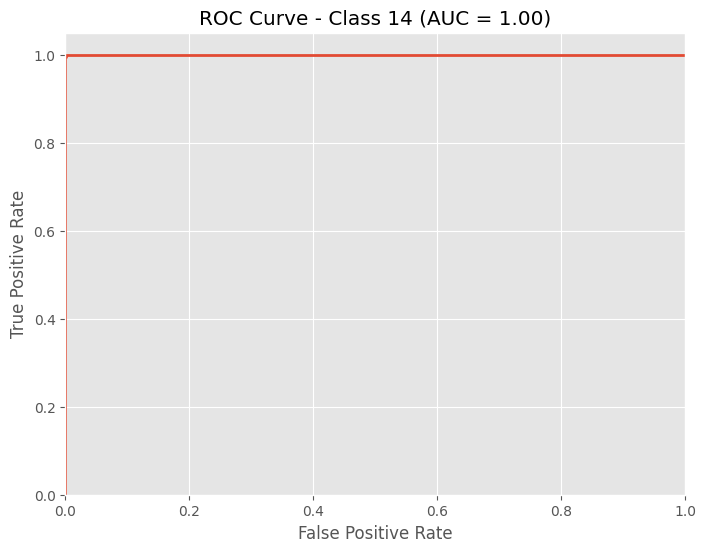

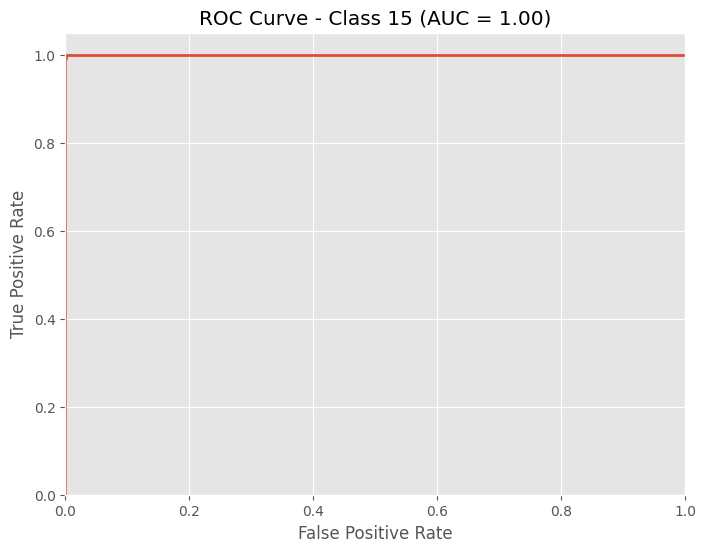

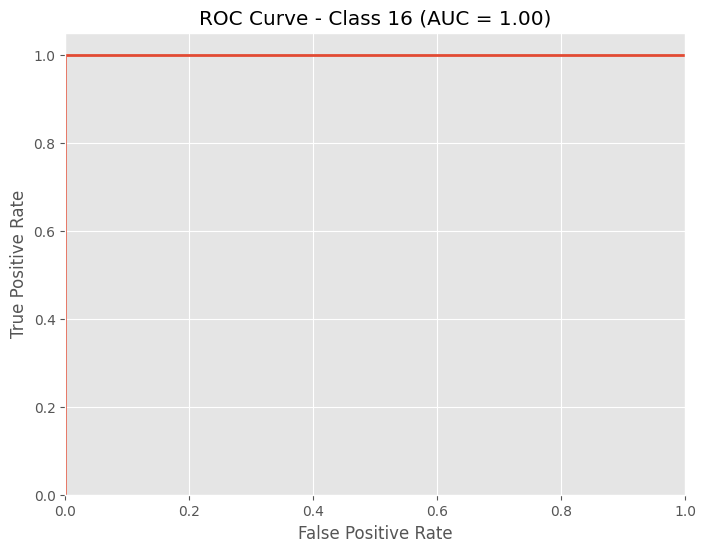

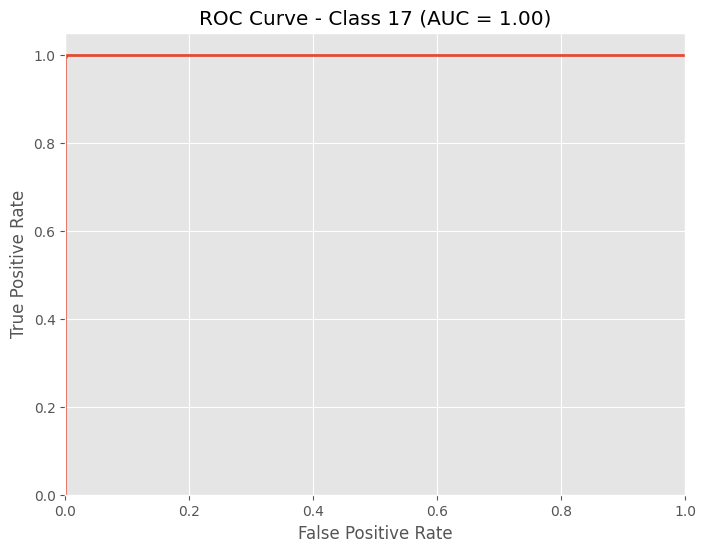

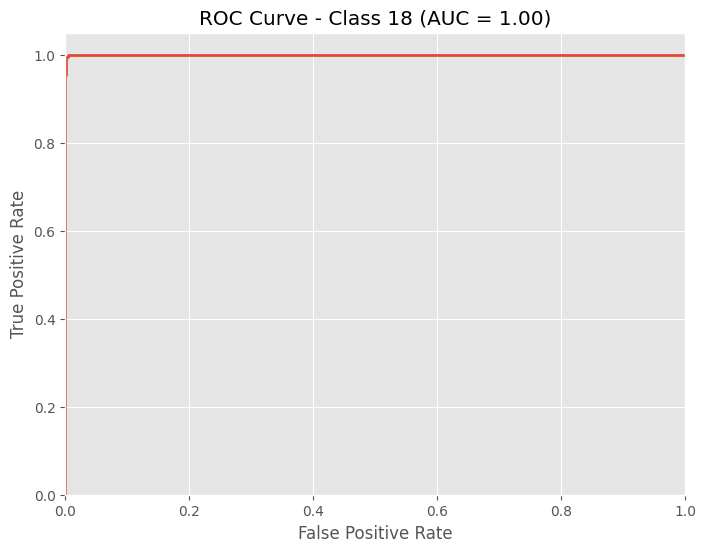

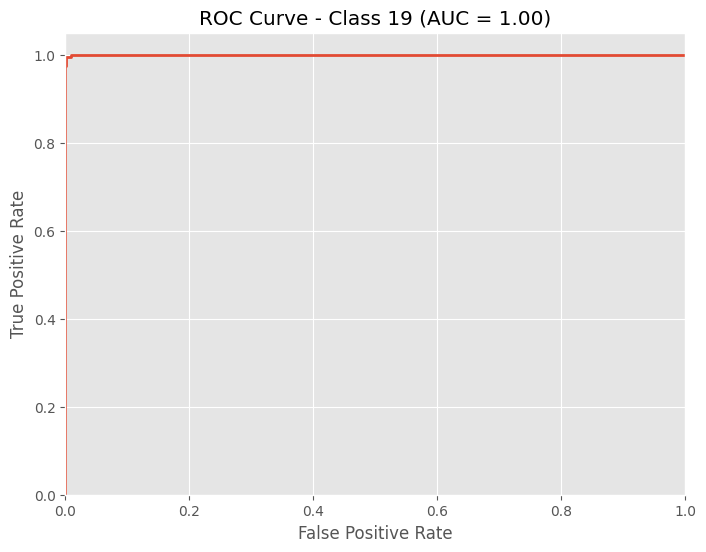

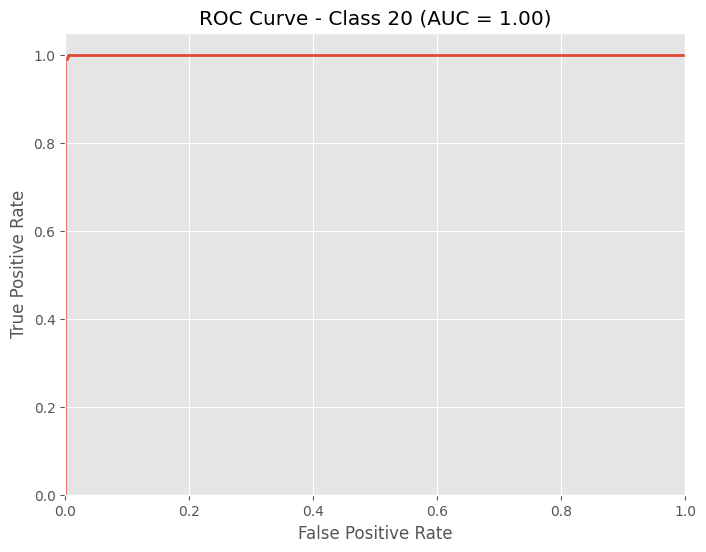

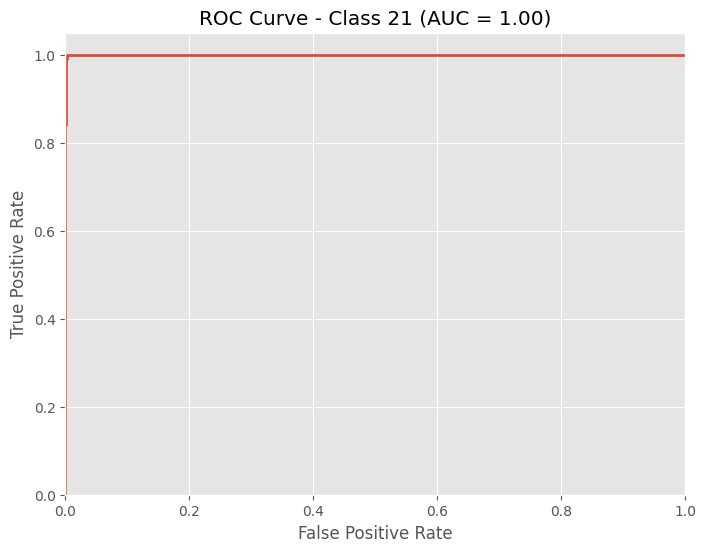

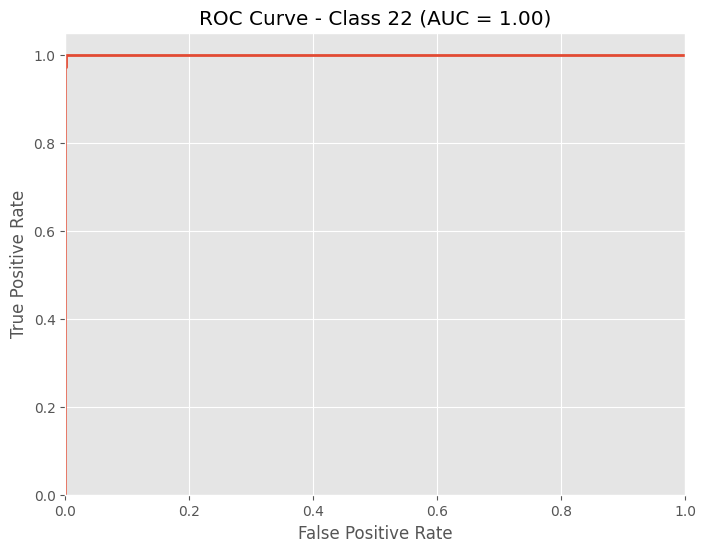

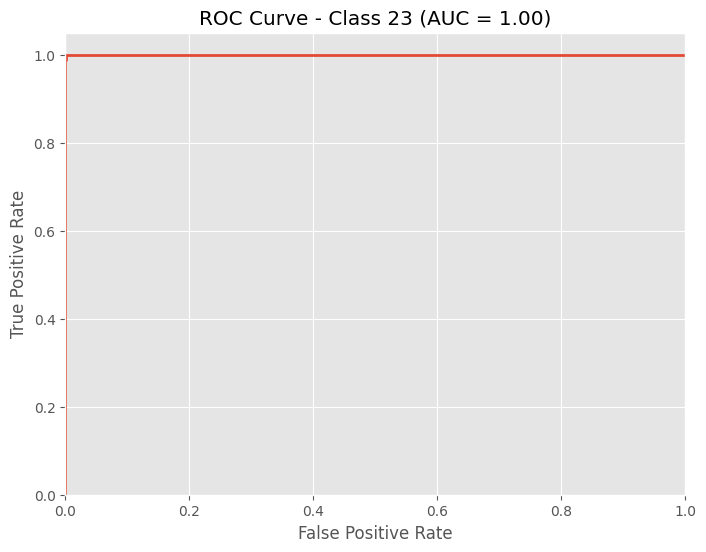

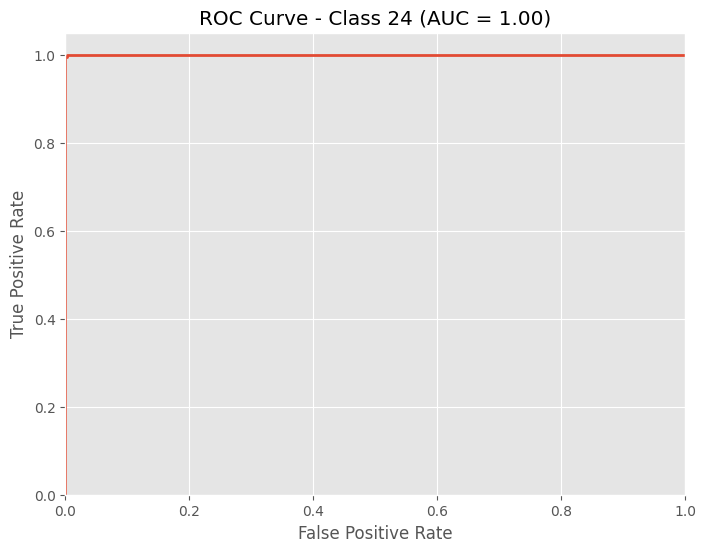

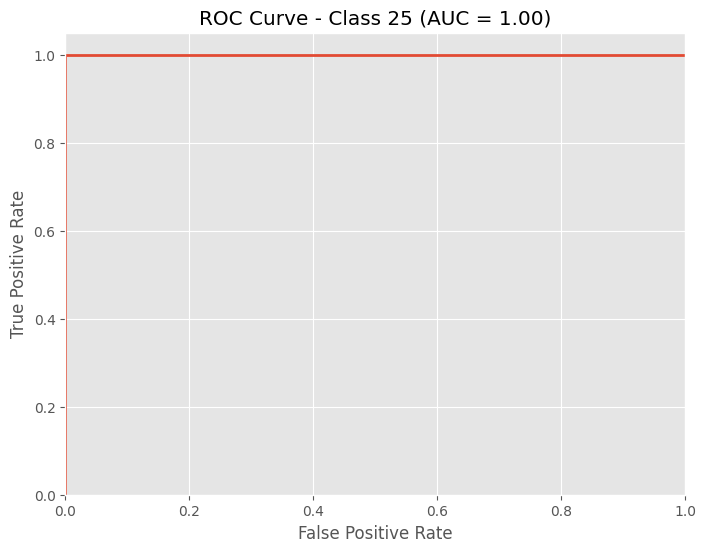

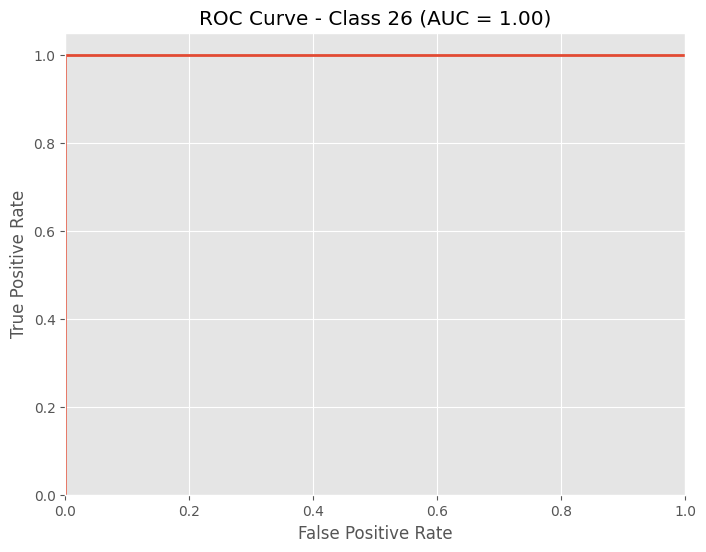

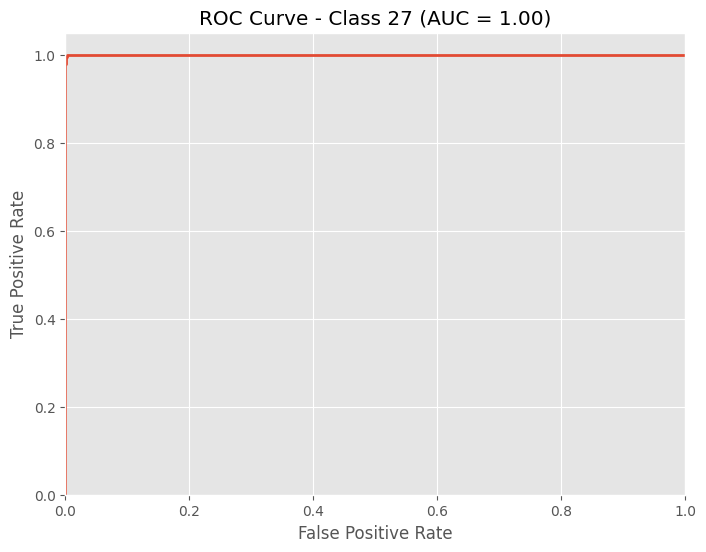

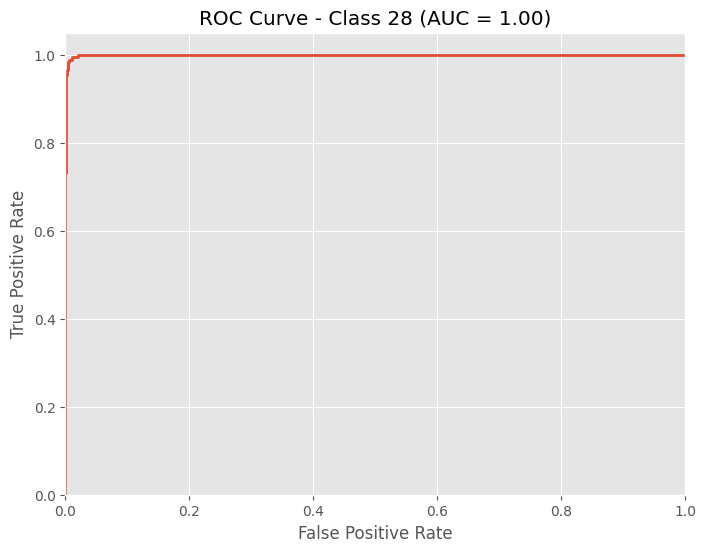

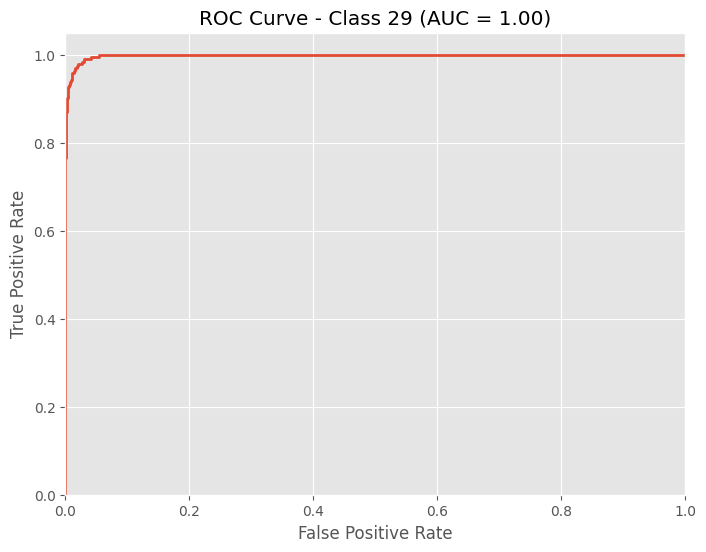

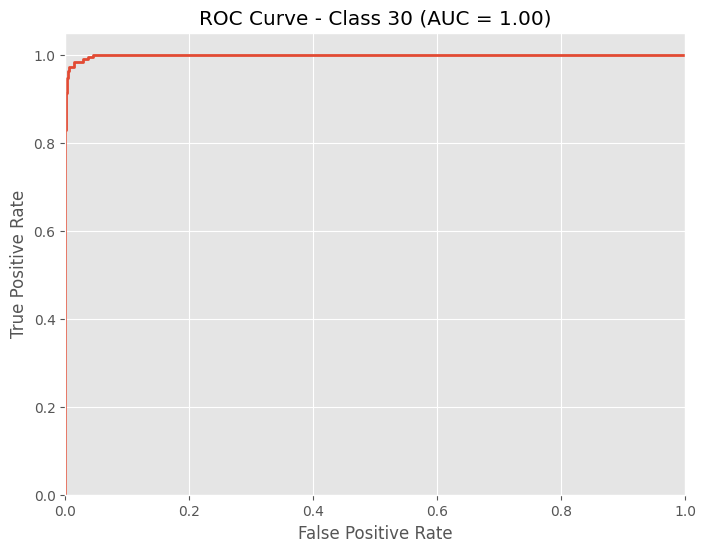

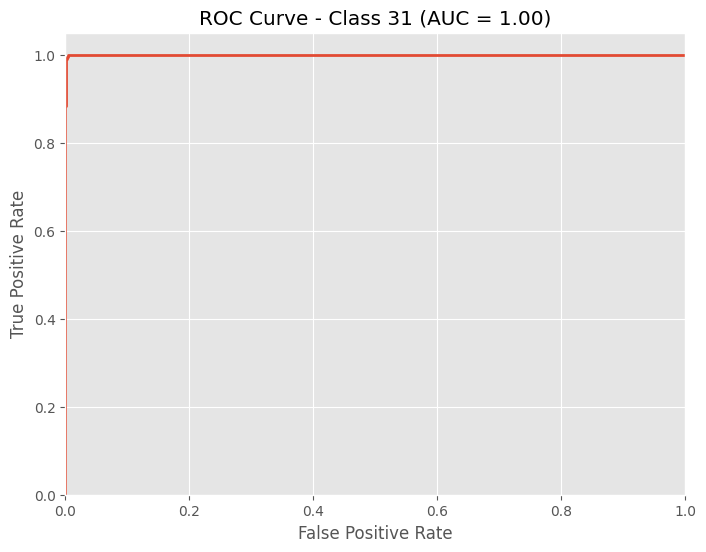

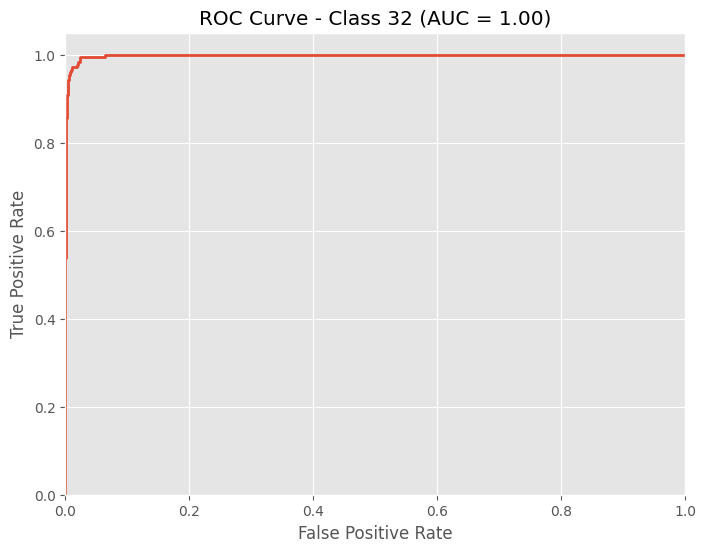

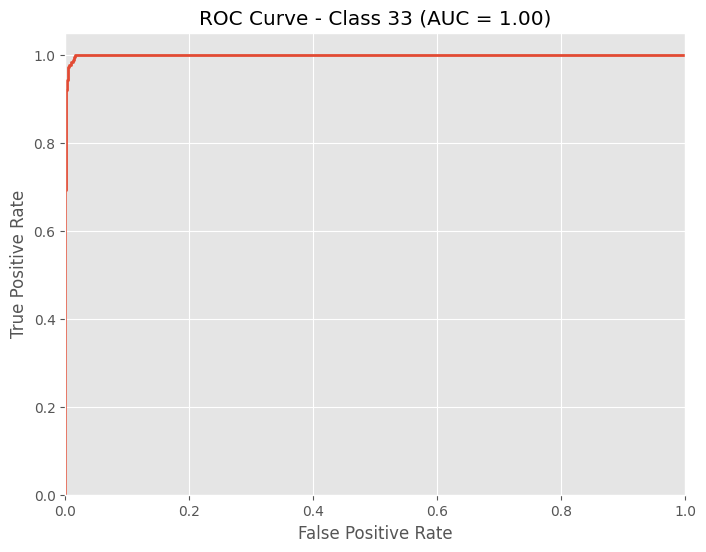

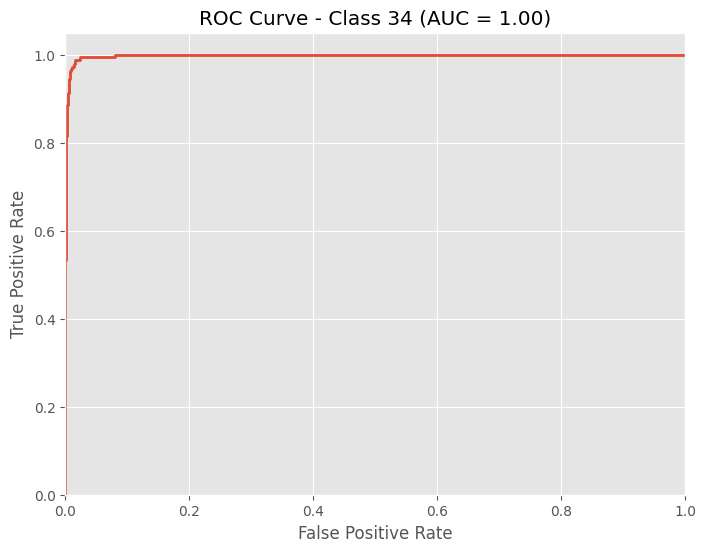

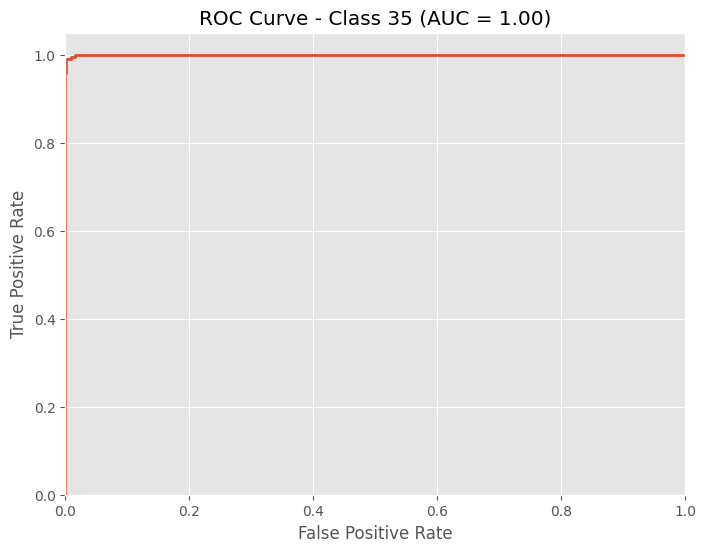

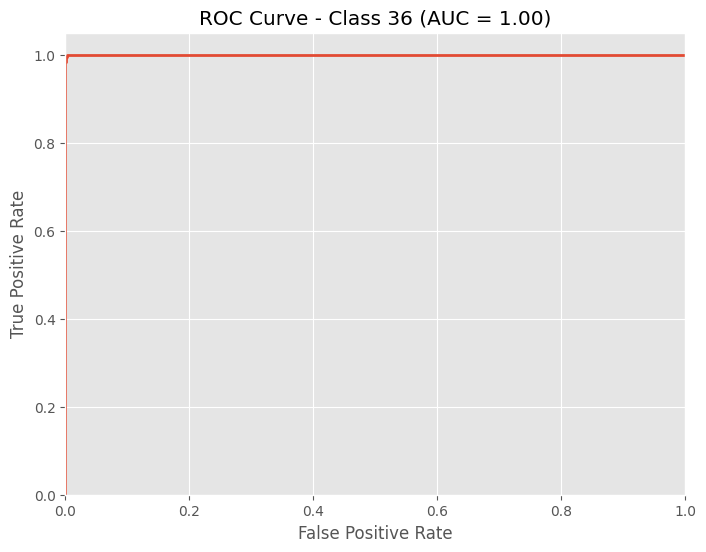

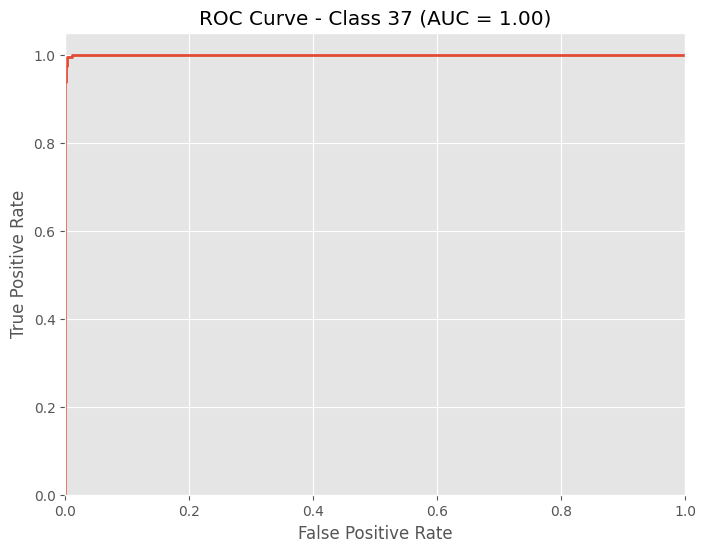

In [27]:
# Assuming you have a trained model and test data
predicted_probs = resnet152v2_model.predict(test_gen)  # Use the test generator to predict

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Initialize dictionaries to store fpr, tpr, and auc for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curves and AUC for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_gen.classes == i, predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot each ROC curve separately with gaps
for i in range(num_classes):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr[i], tpr[i], lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.show()


In [28]:
os.makedirs('/kaggle/working/models/output')

resnet152v2_model.save('/kaggle/working/models/output/resnet152_v2.keras')